In [ ]:
import os
import pickle
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import json
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        image, label = self.dataset[i]
        input = image
        output = image
        return input,output

train_set = CustomDataSet(train_set_orig)
valid_set = CustomDataSet(valid_set_orig)



In [3]:
class Autoencoder_Conv(nn.Module):
    def __init__(self, n=28*28,p=0.2):
        super().__init__()             
        self.n = n
        self.p = p

        #Encoder
        self.encoder = nn.Sequential(
            
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3), #(1, 28, 28) -> (16, 26, 26)
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.MaxPool2d(kernel_size=2,stride=2), # (16, 26, 26) -> (16, 13, 13)
            
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3), # (16, 13, 13) a (32, 11, 11)
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.MaxPool2d(kernel_size=2,stride=2), #(32, 11, 11) -> (32, 5, 5)

            
            nn.Flatten(),
            nn.Linear(32*5*5,self.n), #(32, 5, 5) -> 32*5*5
            nn.ReLU(),
            nn.Dropout(self.p) # 32*5*5 -> n
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Linear(in_features=self.n,out_features=32*5*5), # n -> 32*5*5
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Unflatten(1,(32,5,5)), # 32*5*5 -> (32, 5, 5)

            nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=5,stride=2,padding=2,output_padding=0,dilation=2), # (32, 5, 5) -> (16, 13, 13)
            nn.ReLU(),
            nn.Dropout(self.p),

            nn.ConvTranspose2d(in_channels=16,out_channels=1,kernel_size=6,stride=2,padding=1,output_padding=0,dilation=1), # (16, 13, 13) -> (1, 28, 28)
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def batch(x):
  return x.to(device).unsqueeze(0) # (28,18) --> (1,18,18)

def unbatch(x):
  return x.squeeze().detach().cpu().numpy() # (28,28) --> (1,28,28)

labels_names = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot",
}

batch_size = 50

train_loader = DataLoader(dataset=train_set_orig, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set_orig, batch_size=batch_size, shuffle=True)



In [ ]:
class AutoencoderConv2(nn.Module):
    def __init__(self, n=128, p=0.2):
        super().__init__()
        self.n = n
        self.p = p

        # Encoder
        self.encoder = nn.Sequential(
            # Capa 1: de (1,28,28) a (32,28,28)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32,28,28) -> (32,14,14)
            nn.Dropout(p),
            
            # Capa 2: de (32,14,14) a (64,14,14)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64,14,14) -> (64,7,7)
            nn.Dropout(p),
            
            nn.Flatten(),  # (64,7,7) -> 3136
            nn.Linear(3136, n),
            nn.ReLU(),
            nn.Dropout(p)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(n, 3136),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (64, 7, 7)),
            
            # Capa 1: de (64,7,7) a (32,14,14)
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(p),
            
            # Capa 2: de (32,14,14) a (1,28,28)
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
    model.train()

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_correct = 0
    sum_loss = 0
    sum_batch_avg_loss = 0
    num_processed_samples = 0

    for batch, (X, y) in enumerate(dataloader):

        batch_size = len(X) 
        num_processed_samples += batch_size

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avg_loss = loss.item()
        sum_batch_avg_loss += batch_avg_loss

        # Calculo el número de predicciones correctas
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % (num_batches // 3) == 0:
            print(f"Batch: {batch}, Loss: {batch_avg_loss}")

    avg_loss = sum_batch_avg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision


def valid_loop(dataloader, model, loss_fn):

    model.eval()

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avg_loss = 0
    sum_correct = 0
    num_processed_samples = 0

    with torch.inference_mode():
        for X, y in dataloader:

            batch_size = len(X)
            num_processed_samples += batch_size

            pred = model(X)
            loss = loss_fn(pred, y)

            batch_avg_loss = loss.item()
            sum_batch_avg_loss += batch_avg_loss

            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = sum_batch_avg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision

In [5]:
# Para crear el clasificador, traigo el autoencoder que mejor performea: Autoencoder_Conv2

import copy

class Clasificador_Conv(nn.Module):
    def __init__(self, autoencoder_conv=None, copy_encoder=True, n=256, p=0.1):

        super().__init__()
        if autoencoder_conv is None: # Si no le asigno un autoencoder, genero uno nuevo basado en el mejor obtenido 

            print("Creating encoder")
            self.n=n
            self.p=p

            self.encoder = nn.Sequential(
            # Capa 1: de (1,28,28) a (32,28,28)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32,28,28) -> (32,14,14)
            nn.Dropout(p),
            
            # Capa 2: de (32,14,14) a (64,14,14)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64,14,14) -> (64,7,7)
            nn.Dropout(p),
            
            nn.Flatten(),  # (64,7,7) -> 3136
            nn.Linear(3136, n),
            nn.ReLU(),
            nn.Dropout(p)
            )

        else: 
            self.n = autoencoder_conv.n
            self.p = autoencoder_conv.p
            if copy_encoder:
                print("Copiando el encoder provisto...")
                self.encoder = copy.deepcopy(autoencoder_conv.encoder) # Si es True, copa al clasificador el encoder del autoencoder seleccionado
            else:
                print("Usando el encoder base...")
                self.encoder = autoencoder_conv.encoder # Si es False, asigna el encoder genérico de la clase

        # Clasificador
        self.clasificador = nn.Sequential(
            nn.Linear(self.n, 10),
        )

        self.clasificador = self.clasificador.to(device)

    def forward(self, x): # Se corrigió la sangría del método forward
        x = self.encoder(x)
        x = self.clasificador(x)
        return x

In [ ]:
# Entrenando Encoder y Clasificador, a partir de autoencoder sin entrenar
n = 256
p = 0.1
learning_rate = 1e-3
batch_size = 50
loss_fn = nn.CrossEntropyLoss()

autoencoder_conv = AutoencoderConv2(n=n, p=p)

# Cargo los pesos ya entrenados previamente al Autoencoder; pero NO LOS USO
autoencoder_conv.load_state_dict(torch.load('/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/Augusto/Facu/En Curso/Redes Neuronales/Trabajo Final/Modelos/conv2.pth',weights_only=True)['model_state_dict'])

clasificador_conv = Clasificador_Conv(autoencoder_conv=autoencoder_conv, copy_encoder=False) # NO USO LOS PESOS YA ENTRENADOS
model = clasificador_conv
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Acá es dónde parametrizo qué entrenar: si el clasificador solo, o el clasificador junto con el encoder
                                                                   # En este caso, entreno TODOS los parámetros, incluyendo el encoder

num_epochs = 20

list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
  train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
  valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn)
  list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
  list_train_precision_incorrecta.append(train_precision_incorrecta)
  list_train_precision.append(train_precision)
  list_valid_precision.append(valid_precision)
  if epoch % 5 == 0:
    print("Error de entrenamiento sobre conjunto de entrenaminento:",train_avg_loss_incorrecta)
    print("Error de evaluación sobre conjunto de entrenamiento:",train_avg_loss)
    print("Error de evaluación sobre conjunto de validación:",valid_avg_loss)
    print("Precisión de entrenamiento sobre conjunto de entrenamiento :",train_precision_incorrecta)
    print("Precisión de evaluación sobre conjunto de entrenamiento:",train_precision)
    print("Precisión de evaluación sobre conjunto de validación:",valid_precision)
print("Done!")

train_avg_loss_incorrecta_1 = list_train_avg_loss_incorrecta
train_avg_loss_1 = list_train_avg_loss
valid_avg_loss_1 = list_valid_avg_loss
train_precision_incorrecta_1 = list_train_precision_incorrecta
train_precision_1 = list_train_precision
valid_precision_1 = list_valid_precision

torch.save(model, 'modelo_clasificador.pth')


Usando el encoder base...
Epoch 1
-------------------------------
Batch: 0, Loss: 2.6281259059906006
Batch: 400, Loss: 0.466660737991333
Batch: 800, Loss: 0.4120791554450989
Error de entrenamiento sobre conjunto de entrenaminento: 0.4099965215288103
Error de evaluación sobre conjunto de entrenamiento: 0.2724133101726572
Error de evaluación sobre conjunto de validación: 0.3165648276358843
Precisión de entrenamiento sobre conjunto de entrenamiento : 0.85215
Precisión de evaluación sobre conjunto de entrenamiento: 0.9004833333333333
Precisión de evaluación sobre conjunto de validación: 0.884
Epoch 2
-------------------------------
Batch: 0, Loss: 0.15066413581371307
Batch: 400, Loss: 0.4841137230396271
Batch: 800, Loss: 0.36925286054611206
Epoch 3
-------------------------------
Batch: 0, Loss: 0.17911073565483093
Batch: 400, Loss: 0.23355790972709656
Batch: 800, Loss: 0.13302886486053467
Epoch 4
-------------------------------
Batch: 0, Loss: 0.3137231171131134
Batch: 400, Loss: 0.232211

In [ ]:
# Entrenamiento del clasificador (solo), con el Autoencoder YA ENTRENADO POR SEPARADO
n = 256
p = 0.1
learning_rate = 1e-3
batch_size = 50
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(dataset=train_set_orig, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set_orig, batch_size=batch_size, shuffle=True)

autoencoder_conv = AutoencoderConv2(n=n, p=p)
autoencoder_conv.load_state_dict(torch.load('/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/Augusto/Facu/En Curso/Redes Neuronales/Trabajo Final/conv2.pth',weights_only=True)['model_state_dict'])

clasificador_conv = Clasificador_Conv(autoencoder_conv=autoencoder_conv, copy_encoder=True) # copy_encoder = True, para que copie el Autoencoder de original
model = clasificador_conv
optimizer = torch.optim.Adam(model.clasificador.parameters(), lr=learning_rate) # Entreno SOLO el clasificador!

num_epochs = 20

list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
  train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
  valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn)
  list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
  list_train_precision_incorrecta.append(train_precision_incorrecta)
  list_train_precision.append(train_precision)
  list_valid_precision.append(valid_precision)
  if epoch % 5 == 0:
    print("Error de entrenamiento sobre conjunto de entrenaminento:",train_avg_loss_incorrecta)
    print("Error de evaluación sobre conjunto de entrenamiento:",train_avg_loss)
    print("Error de evaluación sobre conjunto de validación:",valid_avg_loss)
    print("Precisión de entrenamiento sobre conjunto de entrenamiento :",train_precision_incorrecta)
    print("Precisión de evaluación sobre conjunto de entrenamiento:",train_precision)
    print("Precisión de evaluación sobre conjunto de validación:",valid_precision)
print("Done!")


train_avg_loss_incorrecta_2 = list_train_avg_loss_incorrecta
train_avg_loss_2 = list_train_avg_loss
valid_avg_loss_2 = list_valid_avg_loss
train_precision_incorrecta_2 = list_train_precision_incorrecta
train_precision_2 = list_train_precision
valid_precision_2 = list_valid_precision

In [13]:
torch.save(model.state_dict(),'model.state_dict.pth')

In [ ]:
# Entrenamiento del Encoder y el Clasificador, usando un Autoencoder YA ENTRENADO INCIALMENTE
n = 256 
p = 0.1
learning_rate = 1e-3
batch_size = 50
loss_fn = nn.CrossEntropyLoss()

clasificador_conv = Clasificador_Conv(autoencoder_conv = AutoencoderConv2(n=n,p=p))
model = clasificador_conv
optimizer = torch.optim.Adam(model.clasificador.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_set_orig, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set_orig, batch_size=batch_size, shuffle=True)

autoencoder_conv.load_state_dict(torch.load('/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/Augusto/Facu/En Curso/Redes Neuronales/Trabajo Final/conv2.pth')['model_state_dict'])

clasificador_conv = Clasificador_Conv(autoencoder_conv=autoencoder_conv, copy_encoder=True) # copy_encoder = True, para que copie el Autoencoder de original
model = clasificador_conv
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20

list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
  train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
  valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn)
  list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
  list_train_precision_incorrecta.append(train_precision_incorrecta)
  list_train_precision.append(train_precision)
  list_valid_precision.append(valid_precision)
  if epoch % 5 == 0:
    print("Error de entrenamiento sobre conjunto de entrenaminento:",train_avg_loss_incorrecta)
    print("Error de evaluación sobre conjunto de entrenamiento:",train_avg_loss)
    print("Error de evaluación sobre conjunto de validación:",valid_avg_loss)
    print("Precisión de entrenamiento sobre conjunto de entrenamiento :",train_precision_incorrecta)
    print("Precisión de evaluación sobre conjunto de entrenamiento:",train_precision)
    print("Precisión de evaluación sobre conjunto de validación:",valid_precision)
print("Done!")


train_avg_loss_incorrecta_3 = list_train_avg_loss_incorrecta
train_avg_loss_3 = list_train_avg_loss
valid_avg_loss_3 = list_valid_avg_loss
train_precision_incorrecta_3 = list_train_precision_incorrecta
train_precision_3 = list_train_precision
valid_precision_3 = list_valid_precision


In [ ]:
# Entrenamiento  del Clasificador, usando un Autoencoder SIN ENTRENAR
n = 256 
p = 0.1
learning_rate = 1e-3
batch_size = 50
loss_fn = nn.CrossEntropyLoss()

clasificador_conv = Clasificador_Conv(autoencoder_conv = AutoencoderConv2(n=n,p=p))
model2 = clasificador_conv
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_set_orig, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set_orig, batch_size=batch_size, shuffle=True)

autoencoder_conv.load_state_dict(torch.load('/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/Augusto/Facu/En Curso/Redes Neuronales/Trabajo Final/conv2.pth')['model_state_dict'])

clasificador_conv = Clasificador_Conv(autoencoder_conv=autoencoder_conv, copy_encoder=False)
model2 = clasificador_conv
optimizer = torch.optim.Adam(model2.clasificador.parameters(), lr=learning_rate)

num_epochs = 20

list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model2,loss_fn,optimizer)
  train_avg_loss,train_precision = valid_loop(train_loader,model2,loss_fn)
  valid_avg_loss,valid_precision = valid_loop(valid_loader,model2,loss_fn)
  list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
  list_train_precision_incorrecta.append(train_precision_incorrecta)
  list_train_precision.append(train_precision)
  list_valid_precision.append(valid_precision)
  if epoch % 5 == 0:
    print("Error de entrenamiento sobre conjunto de entrenamiento:",train_avg_loss_incorrecta)
    print("Error de evaluación sobre conjunto de entrenamiento:",train_avg_loss)
    print("Error de evaluación sobre conjunto de validación:",valid_avg_loss)
    print("Precisión de entrenamiento sobre conjunto de entrenamiento :",train_precision_incorrecta)
    print("Precisión de evaluación sobre conjunto de entrenamiento:",train_precision)
    print("Precisión de evaluación sobre conjunto de validación:",valid_precision)
print("Done!")


train_avg_loss_incorrecta_4 = list_train_avg_loss_incorrecta
train_avg_loss_4 = list_train_avg_loss
valid_avg_loss_4 = list_valid_avg_loss
train_precision_incorrecta_4 = list_train_precision_incorrecta
train_precision_4 = list_train_precision
valid_precision_4 = list_valid_precision

In [ ]:
clasif_results1 = [[train_avg_loss_incorrecta_1],[train_avg_loss_1],[valid_avg_loss_1],[train_precision_incorrecta_1],[train_precision_1],[valid_precision_1]]
clasif_results2 = [[train_avg_loss_incorrecta_2],[train_avg_loss_2],[valid_avg_loss_2],[train_precision_incorrecta_2],[train_precision_2],[valid_precision_2]]
clasif_results3 = [[train_avg_loss_incorrecta_3],[train_avg_loss_3],[valid_avg_loss_3],[train_precision_incorrecta_3],[train_precision_3],[valid_precision_3]]
clasif_results4 = [[train_avg_loss_incorrecta_4],[train_avg_loss_4],[valid_avg_loss_4],[train_precision_incorrecta_4],[train_precision_4],[valid_precision_4]]

with open('clasif_results1.pkl', 'wb') as f:
    pickle.dump(clasif_results1, f)

with open('clasif_results2.pkl', 'wb') as f:
    pickle.dump(clasif_results2, f)

with open('clasif_results3.pkl', 'wb') as f:
    pickle.dump(clasif_results3, f)

with open('clasif_results4.pkl', 'wb') as f:
    pickle.dump(clasif_results4, f)

In [ ]:
with open('clasif_results1.pkl','rb') as f:
     clasif_results1 = pickle.load(f)

with open('clasif_results2.pkl','rb') as f:
    clasif_results2 = pickle.load(f)

with open('clasif_results3.pkl','rb') as f:
    clasif_results3 = pickle.load(f)
len(clasif_results1[0][0])

with open('clasif_results4.pkl','rb') as f:
    clasif_results4 = pickle.load(f)

Creating encoder


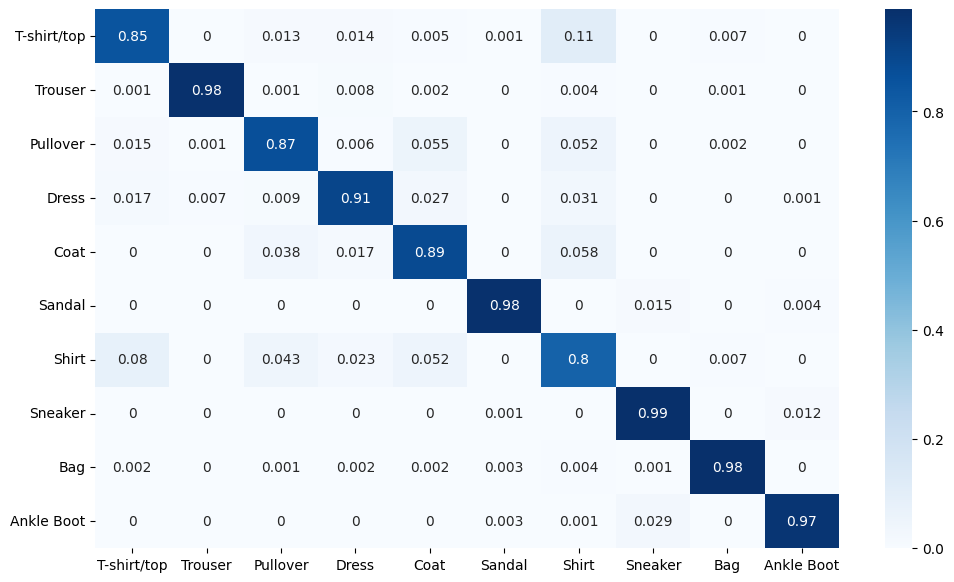

In [43]:

model1 = Clasificador_Conv()
model1.load_state_dict(torch.load('model.state_dict.pth',weights_only=True))
model1.eval()

y_pred = []
y_true = []

#iterate over test data
size = len(valid_loader.dataset)
for batch, (inputs,labels) in enumerate(valid_loader):
    # Move inputs to the same device as the model
    inputs = inputs.to(device)
    outputs = model1(inputs) # Feed Network
    outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
    y_pred.extend(outputs) # Store Prediction
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Store Ground Truth


classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle Boot"]


cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis],
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
svm = sn.heatmap(df_cm,cmap='Blues', annot=True)
figure = svm.get_figure()
figure.savefig('/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/Augusto/Facu/En Curso/Redes Neuronales/Trabajo Final/Gráficos/Mapa de calor.png', dpi = 500)